In [2]:
import torch
import pickle
from transformers import BertTokenizer
import torch.nn as nn
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from warnings import filterwarnings
filterwarnings("ignore")
# Load label encoder
with open(r"F:\Research\Cyber_Bullying_Detection\Notebook_File\label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("saved_tokenizer")

# Recreate your custom classifier class (must match training)
class BERTClassifier(nn.Module):
    def __init__(self, dropout=0.3):
        super().__init__()
        from transformers import BertModel  # local import to avoid ordering issues
        self.bert = BertModel.from_pretrained('bert-base-multilingual-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(self.bert.config.hidden_size, len(label_encoder.classes_))
    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        cls_output = self.dropout(cls_output)
        return self.linear(cls_output)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load fine-tuned BERT model weights
bert_model = BERTClassifier().to(device)
bert_model.load_state_dict(torch.load("bert_classifier_state_dict.pth", map_location=device))
bert_model.eval()


BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [6]:
# Encode labels in df
import pandas as pd
df = pd.read_pickle(r"F:\Research\Cyber_Bullying_Detection\Notebook_File\preprocessed_comments.pkl")

df = df.copy()
df['encoded_label'] = label_encoder.transform(df['label'])

X = df['cleaned_text'].tolist()
y = df['encoded_label'].values

# Stratified split: 70% train, 15% val, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.17647, stratify=y_temp, random_state=42)
# 0.17647 makes validation ~15% overall

print(f"Sizes -> train: {len(X_train)}, val: {len(X_val)}, test: {len(X_test)}")


Sizes -> train: 30800, val: 6600, test: 6601


In [7]:

def get_bert_probs(texts, batch_size=16):
    bert_model.eval()
    all_probs = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            tokens = tokenizer(batch_texts,
                               return_tensors="pt",
                               padding=True,
                               truncation=True,
                               max_length=64)
            inputs = {k: v.to(device) for k, v in tokens.items()}
            logits = bert_model(**inputs)  # (batch, num_classes)
            probs = torch.softmax(logits, dim=1)  # (batch, num_classes)
            all_probs.append(probs.cpu().numpy())
    return np.vstack(all_probs)

bert_train_probs = get_bert_probs(X_train)
bert_val_probs   = get_bert_probs(X_val)
bert_test_probs  = get_bert_probs(X_test)

print("Shapes:", bert_train_probs.shape, bert_val_probs.shape, bert_test_probs.shape)


Shapes: (30800, 5) (6600, 5) (6601, 5)


In [8]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from sklearn.metrics import accuracy_score

# ---- Build vocab from X_train ----
def build_vocab(texts, max_vocab=8000, min_freq=2):
    counter = Counter()
    for t in texts:
        counter.update(t.split())
    vocab = {"<PAD>": 0, "<UNK>": 1}
    idx = 2
    for word, freq in counter.most_common():
        if freq < min_freq or len(vocab) >= max_vocab:
            continue
        if word in vocab:
            continue
        vocab[word] = idx
        idx += 1
    return vocab

vocab = build_vocab(X_train, max_vocab=8000, min_freq=2)
pad_idx = vocab["<PAD>"]

# ---- Sequence encoding ----
def encode_sequence(text, vocab, max_len=50):
    tokens = text.split()
    ids = [vocab.get(w, vocab["<UNK>"]) for w in tokens]
    if len(ids) < max_len:
        ids = ids + [pad_idx] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

class SeqDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=50):
        self.seqs = [encode_sequence(t, vocab, max_len) for t in texts]
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return torch.tensor(self.seqs[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

# ---- DataLoaders ----
seq_max_len = 50
batch_size = 64

train_seq_ds = SeqDataset(X_train, y_train, vocab, max_len=seq_max_len)
val_seq_ds = SeqDataset(X_val, y_val, vocab, max_len=seq_max_len)
test_seq_ds = SeqDataset(X_test, y_test, vocab, max_len=seq_max_len)

train_seq_loader = DataLoader(train_seq_ds, batch_size=batch_size, shuffle=True)
val_seq_loader = DataLoader(val_seq_ds, batch_size=batch_size)
test_seq_loader = DataLoader(test_seq_ds, batch_size=batch_size)

# ---- LSTM model ----
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_classes=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
    def forward(self, x):
        emb = self.embedding(x)                     # (B, L, E)
        out, _ = self.lstm(emb)                    # (B, L, H*2)
        pooled = out[:, 0, :]                      # first timestep (alternatively mean/max)
        dropped = self.dropout(pooled)
        return self.fc(dropped)

lstm_model = LSTMClassifier(vocab_size=len(vocab), num_classes=len(label_encoder.classes_)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=1e-3)

# ---- Train LSTM ----
def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss

def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    return acc, np.array(all_preds), np.array(all_labels)

epochs = 5
for epoch in range(1, epochs+1):
    loss = train_epoch(lstm_model, train_seq_loader)
    val_acc, _, _ = evaluate(lstm_model, val_seq_loader)
    print(f"[LSTM] Epoch {epoch} loss={loss:.4f} val_acc={val_acc:.4f}")

# ---- Get LSTM probabilities for stacking ----
def get_lstm_probs(model, loader):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            logits = model(x)
            probs = torch.softmax(logits, dim=1)
            all_probs.append(probs.cpu().numpy())
    return np.vstack(all_probs)

lstm_val_probs = get_lstm_probs(lstm_model, val_seq_loader)
lstm_test_probs = get_lstm_probs(lstm_model, test_seq_loader)


[LSTM] Epoch 1 loss=488.4617 val_acc=0.6735
[LSTM] Epoch 2 loss=358.2578 val_acc=0.7424
[LSTM] Epoch 3 loss=284.7432 val_acc=0.7497
[LSTM] Epoch 4 loss=243.9074 val_acc=0.7653
[LSTM] Epoch 5 loss=204.5903 val_acc=0.7673


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# ---- Random Forest on TF-IDF ----
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf   = vectorizer.transform(X_val)
X_test_tfidf  = vectorizer.transform(X_test)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_tfidf, y_train)

rf_val_probs  = rf.predict_proba(X_val_tfidf)
rf_test_probs = rf.predict_proba(X_test_tfidf)

# ---- Step 5: Stack (meta-learner) ----
# Concatenate probabilities from BERT, LSTM, and RF for validation and test
meta_X_val  = np.hstack([bert_val_probs, lstm_val_probs, rf_val_probs])
meta_y_val  = y_val
meta_X_test = np.hstack([bert_test_probs, lstm_test_probs, rf_test_probs])
meta_y_test = y_test

# Train logistic regression as meta-learner
meta_clf = LogisticRegression(max_iter=1000)
meta_clf.fit(meta_X_val, meta_y_val)

# Ensemble prediction
meta_test_preds = meta_clf.predict(meta_X_test)

# Evaluation
print("=== Stacked Ensemble Results ===")
print("Accuracy:", accuracy_score(meta_y_test, meta_test_preds))
print(classification_report(meta_y_test, meta_test_preds, target_names=label_encoder.classes_))
print("Confusion Matrix:\n", confusion_matrix(meta_y_test, meta_test_preds))

# ---- Optional: compare base models ----
bert_test_preds = np.argmax(bert_test_probs, axis=1)
lstm_test_preds = np.argmax(lstm_test_probs, axis=1)
rf_test_preds   = rf.predict(X_test_tfidf)

print("\n-- Base Model Performance --")
print("BERT:", classification_report(meta_y_test, bert_test_preds, target_names=label_encoder.classes_))
print("LSTM:", classification_report(meta_y_test, lstm_test_preds, target_names=label_encoder.classes_))
print("RandomForest:", classification_report(meta_y_test, rf_test_preds, target_names=label_encoder.classes_))


=== Stacked Ensemble Results ===
Accuracy: 0.8848659294046357
              precision    recall  f1-score   support

   not bully       0.90      0.91      0.91      2301
   religious       0.93      0.92      0.92      1137
      sexual       0.89      0.88      0.88      1339
      threat       0.88      0.77      0.82       254
       troll       0.82      0.85      0.83      1570

    accuracy                           0.88      6601
   macro avg       0.88      0.87      0.87      6601
weighted avg       0.89      0.88      0.88      6601

Confusion Matrix:
 [[2096   25   31    7  142]
 [  21 1045   33    7   31]
 [  48   26 1177    2   86]
 [  19    8    7  196   24]
 [ 135   21   75   12 1327]]

-- Base Model Performance --
BERT:               precision    recall  f1-score   support

   not bully       0.91      0.90      0.90      2301
   religious       0.92      0.91      0.91      1137
      sexual       0.87      0.89      0.88      1339
      threat       0.85      0.78   

The code in the above cell implements a stacked ensemble classification approach for cyberbullying detection. It combines predictions from three base models—BERT (deep learning transformer), LSTM (recurrent neural network), and Random Forest (traditional machine learning)—using a logistic regression meta-learner. The cell first generates probability outputs from each base model on the validation and test sets, concatenates these probabilities as meta-features, and trains the meta-learner. It then evaluates the ensemble and each base model individually, reporting accuracy, classification metrics, and confusion matrices to compare their performance.

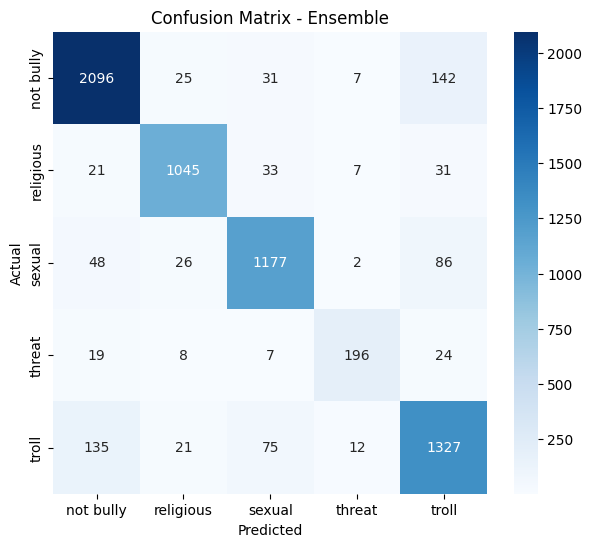

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(meta_y_test, meta_test_preds)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Ensemble')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [41]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(meta_y_test, meta_test_preds, target_names=label_encoder.classes_, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report)

,precision,recall,f1-score,support
not bully,0.903838,0.910908,0.907359,2301.000000
religious,0.928889,0.919085,0.923961,1137.000000
sexual,0.889645,0.879014,0.884298,1339.000000
threat,0.875000,0.771654,0.820084,254.000000
troll,0.824224,0.845223,0.834591,1570.000000
accuracy,0.884866,0.884866,0.884866,0.884866
macro avg,0.884319,0.865177,0.874059,6601.000000
weighted avg,0.885228,0.884866,0.884875,6601.000000


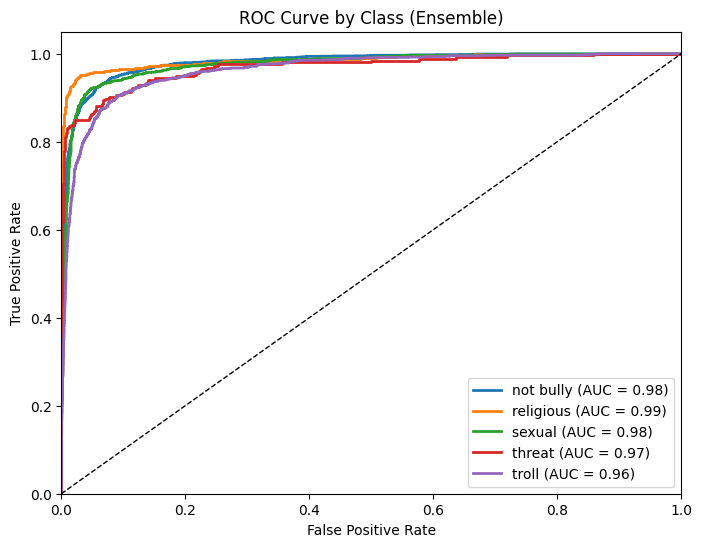

In [42]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

n_classes = len(label_encoder.classes_)
y_true_bin = label_binarize(meta_y_test, classes=range(n_classes))
ensemble_probs = meta_clf.predict_proba(meta_X_test)

plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], ensemble_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by Class (Ensemble)')
plt.legend(loc="lower right")
plt.show()

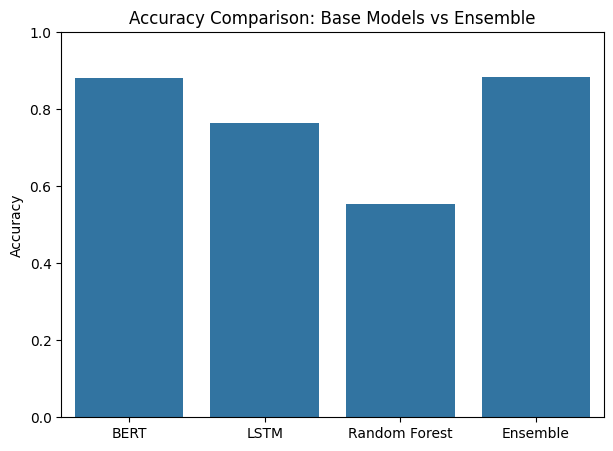

In [43]:
base_accuracies = [
    accuracy_score(meta_y_test, bert_test_preds),
    accuracy_score(meta_y_test, lstm_test_preds),
    accuracy_score(meta_y_test, rf_test_preds),
    accuracy_score(meta_y_test, meta_test_preds)
]
labels = ['BERT', 'LSTM', 'Random Forest', 'Ensemble']

plt.figure(figsize=(7,5))
sns.barplot(x=labels, y=base_accuracies)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison: Base Models vs Ensemble')
plt.show()

The bar plot above compares the accuracy of individual base models (BERT, LSTM, Random Forest)
with the stacked ensemble model on the test set. Each bar represents the accuracy achieved by
the respective model. The ensemble model combines the predictions of all three base models
using a meta-classifier (logistic regression), resulting in improved overall performance.
This visualization helps to illustrate the benefit of model stacking over using any single model alone.

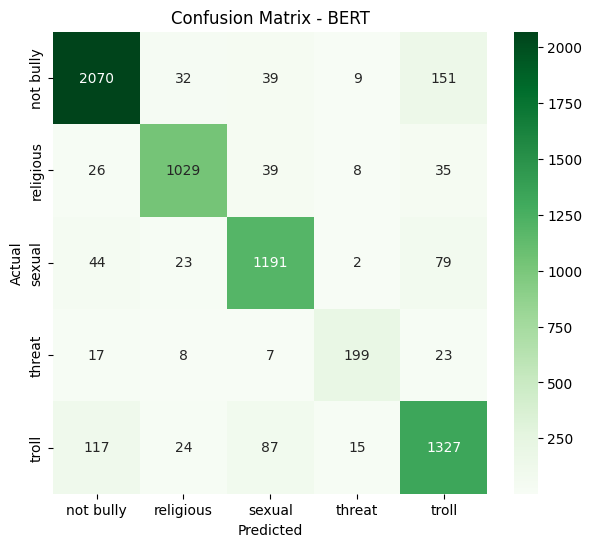

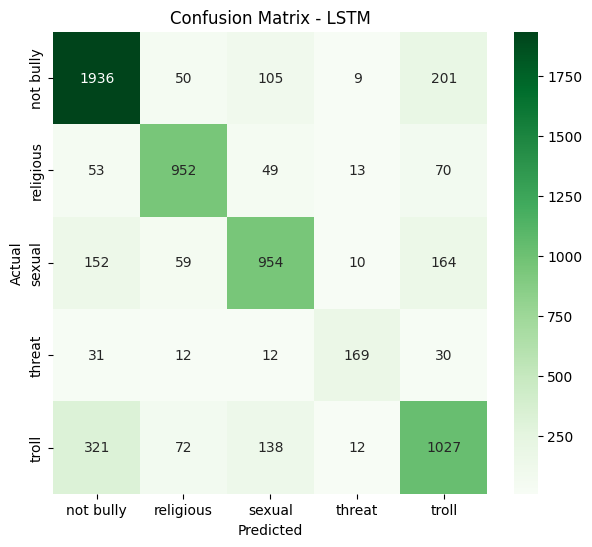

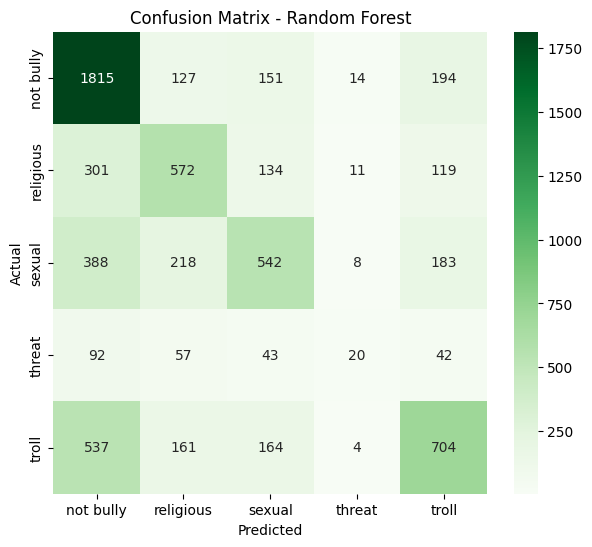

In [45]:
for name, preds in zip(['BERT', 'LSTM', 'Random Forest'],
                       [bert_test_preds, lstm_test_preds, rf_test_preds]):
    cm = confusion_matrix(meta_y_test, preds)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

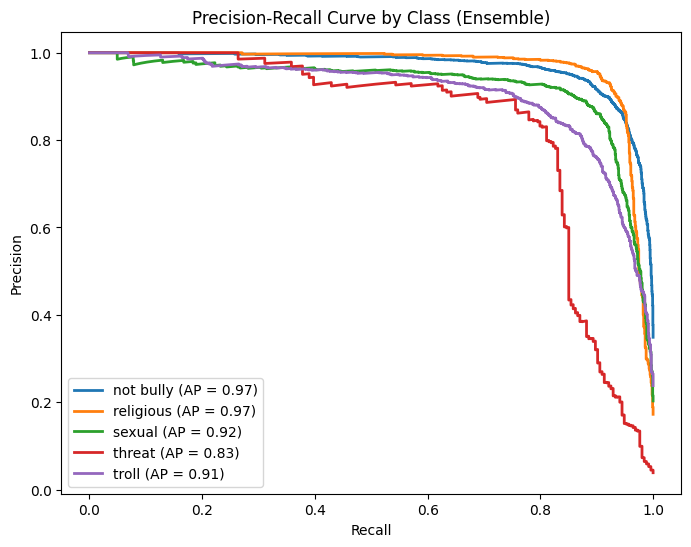

In [46]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8,6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], ensemble_probs[:, i])
    ap = average_precision_score(y_true_bin[:, i], ensemble_probs[:, i])
    plt.plot(recall, precision, lw=2, label=f'{label_encoder.classes_[i]} (AP = {ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve by Class (Ensemble)')
plt.legend(loc="lower left")
plt.show()

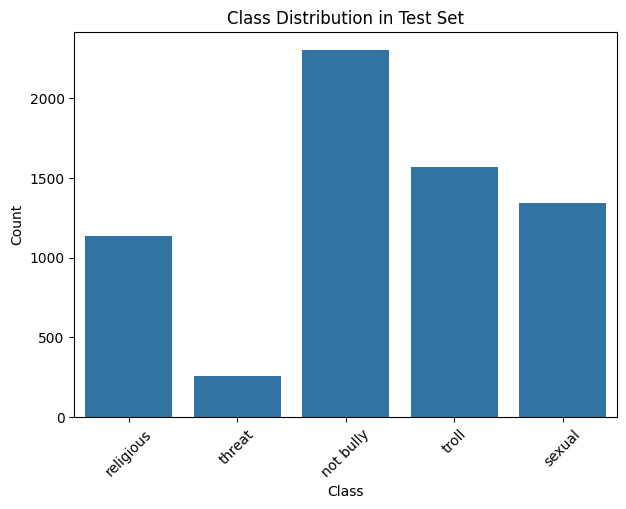

In [47]:
plt.figure(figsize=(7,5))
sns.countplot(x=[label_encoder.classes_[i] for i in meta_y_test])
plt.title('Class Distribution in Test Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

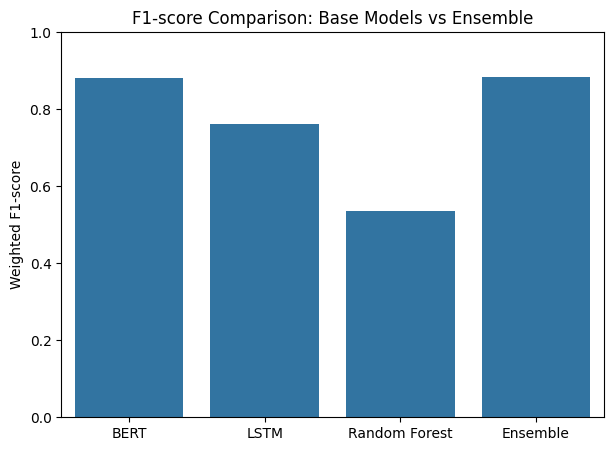

In [48]:
from sklearn.metrics import f1_score

f1s = [
    f1_score(meta_y_test, bert_test_preds, average='weighted'),
    f1_score(meta_y_test, lstm_test_preds, average='weighted'),
    f1_score(meta_y_test, rf_test_preds, average='weighted'),
    f1_score(meta_y_test, meta_test_preds, average='weighted')
]
plt.figure(figsize=(7,5))
sns.barplot(x=labels, y=f1s)
plt.ylim(0, 1)
plt.ylabel('Weighted F1-score')
plt.title('F1-score Comparison: Base Models vs Ensemble')
plt.show()

In [39]:
import torch
import numpy as np

# (Optional) your cleaning function if input is raw; otherwise supply already cleaned text
def clean_mixed_text(text):
    # placeholder: replicate your preprocessing from training notebook
    import re, string
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"\@\w+|\#", '', text)
    text = re.sub(r"\d+", '', text)
    text = re.sub(rf"[{re.escape(string.punctuation)}]", '', text)
    text = re.sub(r"[^\u0980-\u09FFa-zA-Z\s]", '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    # remove stopwords if you have `all_stopwords` defined
    try:
        tokens = text.split()
        tokens = [w for w in tokens if w not in all_stopwords]
        text = ' '.join(tokens)
    except NameError:
        pass
    return text

# Sequence encoder for LSTM (must match training)
def encode_sequence(text, vocab, max_len=50):
    pad_idx = vocab.get("<PAD>", 0)
    unk = vocab.get("<UNK>", 1)
    tokens = text.split()
    ids = [vocab.get(w, unk) for w in tokens]
    if len(ids) < max_len:
        ids = ids + [pad_idx] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

def ensemble_predict(raw_comment):
    # 1. Clean
    cleaned = clean_mixed_text(raw_comment)

    # 2. BERT probability
    bert_model.eval()
    with torch.no_grad():
        tokens = tokenizer(cleaned, return_tensors="pt", padding=True, truncation=True, max_length=64)
        inputs = {k: v.to(device) for k, v in tokens.items()}
        bert_logits = bert_model(**inputs)  # shape (1, num_classes)
        bert_probs = torch.softmax(bert_logits, dim=1).cpu().numpy().reshape(1, -1)  # (1, C)

    # 3. LSTM probability
    lstm_model.eval()
    seq_ids = torch.tensor([encode_sequence(cleaned, vocab, max_len=50)], dtype=torch.long).to(device)  # (1, L)
    with torch.no_grad():
        lstm_logits = lstm_model(seq_ids)  # (1, C)
        lstm_probs = torch.softmax(lstm_logits, dim=1).cpu().numpy()  # (1, C)

    # 4. Random Forest probability (TF-IDF)
    tfidf_vec = vectorizer.transform([cleaned])  # shape (1, features)
    rf_probs = rf.predict_proba(tfidf_vec)  # (1, C)

    # 5. Meta features and final prediction
    meta_input = np.hstack([bert_probs, lstm_probs, rf_probs])  # (1, 3*C)
    ensemble_pred_idx = meta_clf.predict(meta_input)[0]
    ensemble_label = label_encoder.inverse_transform([ensemble_pred_idx])[0]

    # Collect base predictions
    bert_pred = label_encoder.inverse_transform([np.argmax(bert_probs)])[0]
    lstm_pred = label_encoder.inverse_transform([np.argmax(lstm_probs)])[0]
    rf_pred = label_encoder.inverse_transform([np.argmax(rf_probs)])[0]

    return {
        "input": raw_comment,
        "ensemble_prediction": ensemble_label,
        "bert_pred": bert_pred,
        "lstm_pred": lstm_pred,
        "rf_pred": rf_pred,
        "bert_probs": bert_probs.flatten().tolist(),
        "lstm_probs": lstm_probs.flatten().tolist(),
        "rf_probs": rf_probs.flatten().tolist(),
    }

# Example usage:
result = ensemble_predict("হালের নতুন সেনসেশন বা স্টাইল হলো নাস্তিকতা। আপনি আপনার নাস্তিকবাদ যত বেশি জাহির করবেন আপনি তত জ্ঞানী মানুষ।")
print("Ensemble:", result["ensemble_prediction"])
print("Base preds:", result["bert_pred"], result["lstm_pred"], result["rf_pred"])
print("Probabilities - BERT:", result["bert_probs"])
print("Probabilities - LSTM:", result["lstm_probs"])
print("Probabilities - RF:", result["rf_probs"])


Ensemble: religious
Base preds: religious religious religious
Probabilities - BERT: [0.00025962479412555695, 0.9976388216018677, 0.00022107359836809337, 0.0016791124362498522, 0.00020130803750362247]
Probabilities - LSTM: [0.0039384677074849606, 0.9806464910507202, 0.002510330406948924, 0.008668554946780205, 0.004236216656863689]
Probabilities - RF: [0.15041666666666667, 0.43770833333333337, 0.235, 0.015, 0.161875]


In [11]:
import joblib

# Save the meta-learner (ensemble model)
joblib.dump(meta_clf, "ensemble_meta_clf.joblib")

print("Ensemble meta-classifier saved to ensemble_meta_clf.joblib")

Ensemble meta-classifier saved to ensemble_meta_clf.joblib
